# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 1            
model_seed = 1           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6924 | Test Loss 0.6915 | accs Train 0.5200 Test 0.4938


Epoch 100/2000: Train Loss 0.5697 | Test Loss 0.5909 | accs Train 0.6250 Test 0.5950


Epoch 200/2000: Train Loss 0.0283 | Test Loss 0.0395 | accs Train 0.9925 Test 0.9890


Epoch 300/2000: Train Loss 0.0015 | Test Loss 0.0071 | accs Train 1.0000 Test 0.9980


Epoch 400/2000: Train Loss 0.0005 | Test Loss 0.0049 | accs Train 1.0000 Test 0.9985


Epoch 500/2000: Train Loss 0.0003 | Test Loss 0.0038 | accs Train 1.0000 Test 0.9988


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0031 | accs Train 1.0000 Test 0.9990


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0027 | accs Train 1.0000 Test 0.9990


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0025 | accs Train 1.0000 Test 0.9990


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0022 | accs Train 1.0000 Test 0.9990


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0020 | accs Train 1.0000 Test 0.9990


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0019 | accs Train 1.0000 Test 0.9990


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0018 | accs Train 1.0000 Test 0.9990


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0017 | accs Train 1.0000 Test 0.9990


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0016 | accs Train 1.0000 Test 0.9990


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0015 | accs Train 1.0000 Test 0.9990


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0014 | accs Train 1.0000 Test 0.9992


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0014 | accs Train 1.0000 Test 0.9992


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0013 | accs Train 1.0000 Test 0.9992


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0012 | accs Train 1.0000 Test 0.9992


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0012 | accs Train 1.0000 Test 0.9992
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6924 | Test Loss 0.6915 | accs Train 0.5195 Test 0.4935


Epoch 100/2000: Train Loss 0.5711 | Test Loss 0.5846 | accs Train 0.6293 Test 0.6005


Epoch 200/2000: Train Loss 0.0838 | Test Loss 0.0605 | accs Train 0.9707 Test 0.9908


Epoch 300/2000: Train Loss 0.0415 | Test Loss 0.0474 | accs Train 0.9829 Test 0.9810


Epoch 400/2000: Train Loss 0.0329 | Test Loss 0.0575 | accs Train 0.9902 Test 0.9760


Epoch 500/2000: Train Loss 0.0287 | Test Loss 0.0676 | accs Train 0.9902 Test 0.9732


Epoch 600/2000: Train Loss 0.0260 | Test Loss 0.0770 | accs Train 0.9902 Test 0.9712


Epoch 700/2000: Train Loss 0.0243 | Test Loss 0.0870 | accs Train 0.9902 Test 0.9688


Epoch 800/2000: Train Loss 0.0229 | Test Loss 0.0917 | accs Train 0.9902 Test 0.9688


Epoch 900/2000: Train Loss 0.0221 | Test Loss 0.1002 | accs Train 0.9902 Test 0.9683


Epoch 1000/2000: Train Loss 0.0277 | Test Loss 0.1079 | accs Train 0.9854 Test 0.9670


Epoch 1100/2000: Train Loss 0.0197 | Test Loss 0.1116 | accs Train 0.9902 Test 0.9677


Epoch 1200/2000: Train Loss 0.0198 | Test Loss 0.1181 | accs Train 0.9927 Test 0.9667


Epoch 1300/2000: Train Loss 0.0189 | Test Loss 0.1229 | accs Train 0.9927 Test 0.9670


Epoch 1400/2000: Train Loss 0.0165 | Test Loss 0.1264 | accs Train 0.9951 Test 0.9663


Epoch 1500/2000: Train Loss 0.0152 | Test Loss 0.1320 | accs Train 0.9951 Test 0.9667


Epoch 1600/2000: Train Loss 0.0156 | Test Loss 0.1333 | accs Train 0.9902 Test 0.9650


Epoch 1700/2000: Train Loss 0.0134 | Test Loss 0.1396 | accs Train 0.9976 Test 0.9673


Epoch 1800/2000: Train Loss 0.0129 | Test Loss 0.1454 | accs Train 0.9951 Test 0.9660


Epoch 1900/2000: Train Loss 0.0130 | Test Loss 0.1598 | accs Train 0.9976 Test 0.9653


Epoch 2000/2000: Train Loss 0.0112 | Test Loss 0.1627 | accs Train 0.9976 Test 0.9655
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6925 | Test Loss 0.6915 | accs Train 0.5190 Test 0.4945


Epoch 100/2000: Train Loss 0.5866 | Test Loss 0.5919 | accs Train 0.6143 Test 0.5948


Epoch 200/2000: Train Loss 0.1469 | Test Loss 0.0780 | accs Train 0.9548 Test 0.9900


Epoch 300/2000: Train Loss 0.0851 | Test Loss 0.0595 | accs Train 0.9738 Test 0.9862


Epoch 400/2000: Train Loss 0.0670 | Test Loss 0.0728 | accs Train 0.9738 Test 0.9782


Epoch 500/2000: Train Loss 0.0586 | Test Loss 0.0804 | accs Train 0.9762 Test 0.9725


Epoch 600/2000: Train Loss 0.0547 | Test Loss 0.0886 | accs Train 0.9738 Test 0.9698


Epoch 700/2000: Train Loss 0.0535 | Test Loss 0.0935 | accs Train 0.9786 Test 0.9695


Epoch 800/2000: Train Loss 0.0478 | Test Loss 0.0971 | accs Train 0.9786 Test 0.9675


Epoch 900/2000: Train Loss 0.0458 | Test Loss 0.1015 | accs Train 0.9833 Test 0.9677


Epoch 1000/2000: Train Loss 0.0402 | Test Loss 0.1113 | accs Train 0.9881 Test 0.9650


Epoch 1100/2000: Train Loss 0.0382 | Test Loss 0.1180 | accs Train 0.9833 Test 0.9633


Epoch 1200/2000: Train Loss 0.0344 | Test Loss 0.1281 | accs Train 0.9905 Test 0.9623


Epoch 1300/2000: Train Loss 0.0316 | Test Loss 0.1278 | accs Train 0.9905 Test 0.9627


Epoch 1400/2000: Train Loss 0.0288 | Test Loss 0.1366 | accs Train 0.9929 Test 0.9617


Epoch 1500/2000: Train Loss 0.0268 | Test Loss 0.1493 | accs Train 0.9905 Test 0.9595


Epoch 1600/2000: Train Loss 0.0242 | Test Loss 0.1600 | accs Train 0.9905 Test 0.9580


Epoch 1700/2000: Train Loss 0.0222 | Test Loss 0.1763 | accs Train 0.9929 Test 0.9565


Epoch 1800/2000: Train Loss 0.0216 | Test Loss 0.1867 | accs Train 0.9952 Test 0.9547


Epoch 1900/2000: Train Loss 0.0197 | Test Loss 0.1987 | accs Train 0.9929 Test 0.9545


Epoch 2000/2000: Train Loss 0.0255 | Test Loss 0.1797 | accs Train 0.9905 Test 0.9577
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6925 | Test Loss 0.6916 | accs Train 0.5200 Test 0.4953


Epoch 100/2000: Train Loss 0.6001 | Test Loss 0.5873 | accs Train 0.6333 Test 0.6232


Epoch 200/2000: Train Loss 0.3258 | Test Loss 0.1703 | accs Train 0.8689 Test 0.9725


Epoch 300/2000: Train Loss 0.2742 | Test Loss 0.1348 | accs Train 0.8978 Test 0.9918


Epoch 400/2000: Train Loss 0.2458 | Test Loss 0.1313 | accs Train 0.8978 Test 0.9808


Epoch 500/2000: Train Loss 0.2279 | Test Loss 0.1203 | accs Train 0.9111 Test 0.9752


Epoch 600/2000: Train Loss 0.2114 | Test Loss 0.1401 | accs Train 0.9133 Test 0.9615


Epoch 700/2000: Train Loss 0.2020 | Test Loss 0.1324 | accs Train 0.9244 Test 0.9613


Epoch 800/2000: Train Loss 0.1930 | Test Loss 0.1361 | accs Train 0.9311 Test 0.9563


Epoch 900/2000: Train Loss 0.1746 | Test Loss 0.1394 | accs Train 0.9311 Test 0.9540


Epoch 1000/2000: Train Loss 0.1667 | Test Loss 0.1415 | accs Train 0.9378 Test 0.9517


Epoch 1100/2000: Train Loss 0.1563 | Test Loss 0.1570 | accs Train 0.9378 Test 0.9445


Epoch 1200/2000: Train Loss 0.1672 | Test Loss 0.1805 | accs Train 0.9311 Test 0.9320


Epoch 1300/2000: Train Loss 0.1434 | Test Loss 0.1773 | accs Train 0.9378 Test 0.9375


Epoch 1400/2000: Train Loss 0.1372 | Test Loss 0.1720 | accs Train 0.9400 Test 0.9367


Epoch 1500/2000: Train Loss 0.1306 | Test Loss 0.1851 | accs Train 0.9378 Test 0.9320


Epoch 1600/2000: Train Loss 0.1277 | Test Loss 0.1901 | accs Train 0.9378 Test 0.9293


Epoch 1700/2000: Train Loss 0.1196 | Test Loss 0.2074 | accs Train 0.9489 Test 0.9265


Epoch 1800/2000: Train Loss 0.1171 | Test Loss 0.2207 | accs Train 0.9467 Test 0.9217


Epoch 1900/2000: Train Loss 0.1856 | Test Loss 0.2053 | accs Train 0.9333 Test 0.9305


Epoch 2000/2000: Train Loss 0.1082 | Test Loss 0.2395 | accs Train 0.9489 Test 0.9170
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6928 | Test Loss 0.6916 | accs Train 0.5120 Test 0.4963


Epoch 100/2000: Train Loss 0.6357 | Test Loss 0.5978 | accs Train 0.6040 Test 0.6185


Epoch 200/2000: Train Loss 0.4601 | Test Loss 0.2830 | accs Train 0.8060 Test 0.9695


Epoch 300/2000: Train Loss 0.4118 | Test Loss 0.2312 | accs Train 0.8220 Test 0.9615


Epoch 400/2000: Train Loss 0.3889 | Test Loss 0.2397 | accs Train 0.8280 Test 0.9453


Epoch 500/2000: Train Loss 0.3657 | Test Loss 0.2376 | accs Train 0.8340 Test 0.9343


Epoch 600/2000: Train Loss 0.3467 | Test Loss 0.2507 | accs Train 0.8540 Test 0.9297


Epoch 700/2000: Train Loss 0.3327 | Test Loss 0.2562 | accs Train 0.8640 Test 0.9217


Epoch 800/2000: Train Loss 0.3154 | Test Loss 0.2832 | accs Train 0.8600 Test 0.9170


Epoch 900/2000: Train Loss 0.3080 | Test Loss 0.3158 | accs Train 0.8660 Test 0.9042


Epoch 1000/2000: Train Loss 0.2947 | Test Loss 0.3069 | accs Train 0.8820 Test 0.8982


Epoch 1100/2000: Train Loss 0.2876 | Test Loss 0.3331 | accs Train 0.8780 Test 0.8935


Epoch 1200/2000: Train Loss 0.2795 | Test Loss 0.3365 | accs Train 0.8820 Test 0.8945


Epoch 1300/2000: Train Loss 0.2732 | Test Loss 0.3479 | accs Train 0.8840 Test 0.8932


Epoch 1400/2000: Train Loss 0.2672 | Test Loss 0.3637 | accs Train 0.8900 Test 0.8875


Epoch 1500/2000: Train Loss 0.2670 | Test Loss 0.3785 | accs Train 0.8960 Test 0.8825


Epoch 1600/2000: Train Loss 0.2586 | Test Loss 0.3757 | accs Train 0.8920 Test 0.8870


Epoch 1700/2000: Train Loss 0.2567 | Test Loss 0.3877 | accs Train 0.8920 Test 0.8798


Epoch 1800/2000: Train Loss 0.2536 | Test Loss 0.4051 | accs Train 0.8960 Test 0.8780


Epoch 1900/2000: Train Loss 0.2476 | Test Loss 0.4073 | accs Train 0.9000 Test 0.8785


Epoch 2000/2000: Train Loss 0.2429 | Test Loss 0.4150 | accs Train 0.8980 Test 0.8768
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0012 | accs: 0.9992
  10 samples | Test Loss: 0.1627 | accs: 0.9655
  20 samples | Test Loss: 0.1797 | accs: 0.9577
  50 samples | Test Loss: 0.2395 | accs: 0.9170
 100 samples | Test Loss: 0.4150 | accs: 0.8768

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0047 | accs: 1.0000
 Model   20 | Train Loss: 0.0109 | accs: 1.0000
 Model   50 | Train Loss: 0.0552 | accs: 0.9850
 Model  100 | Train Loss: 0.1170 | accs: 0.9850

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3040 | accs: 0.9756
 Model   10 | Train Loss: 0.0113 | accs: 0.9976
 Model   20 | Train Loss: 0.0185 | accs: 0.9951
 Model   50 | Train Loss: 0.0656 | accs: 0.9780
 Model  100 | Train Loss: 0.1346 | accs: 0.9756

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.5614 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

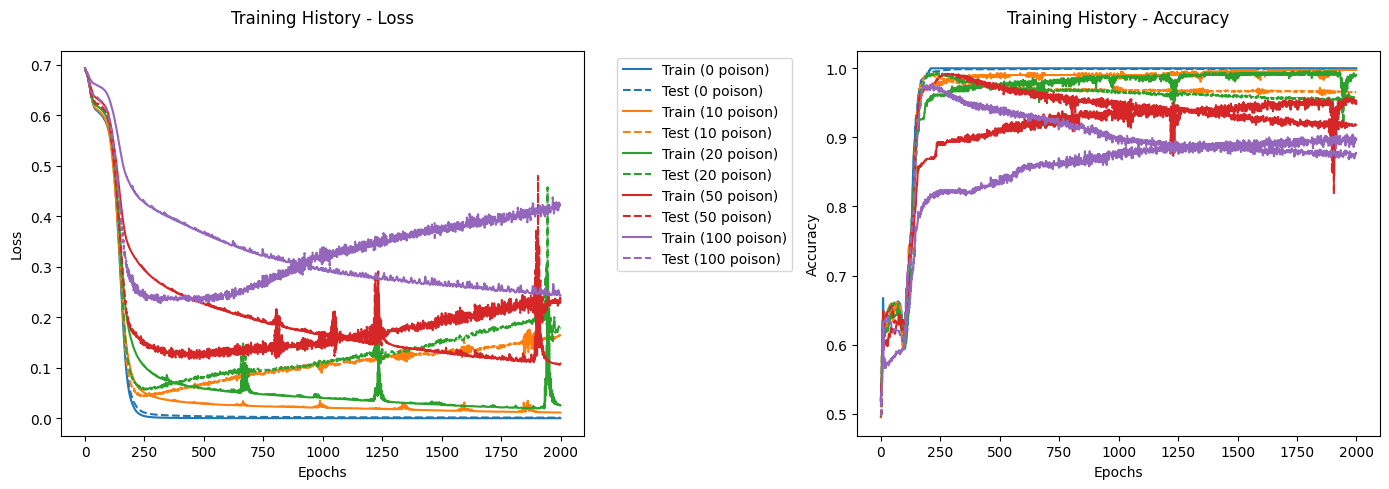

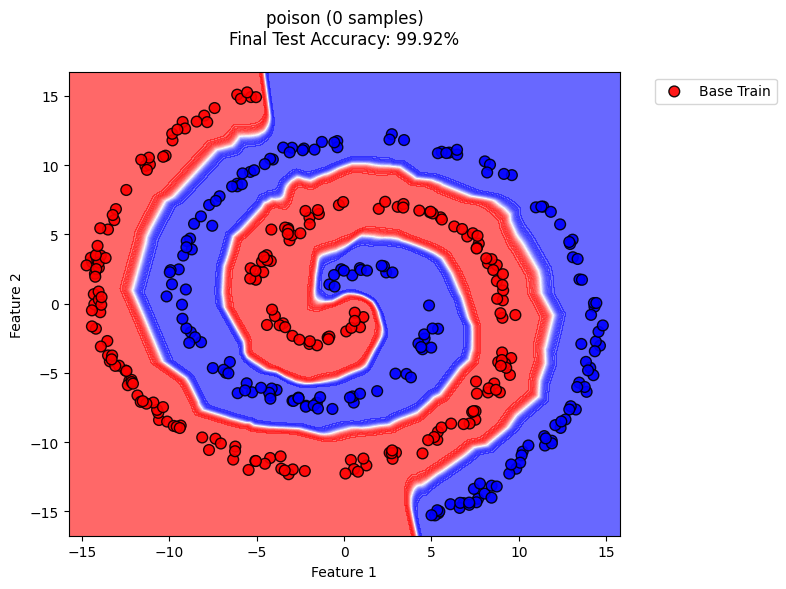

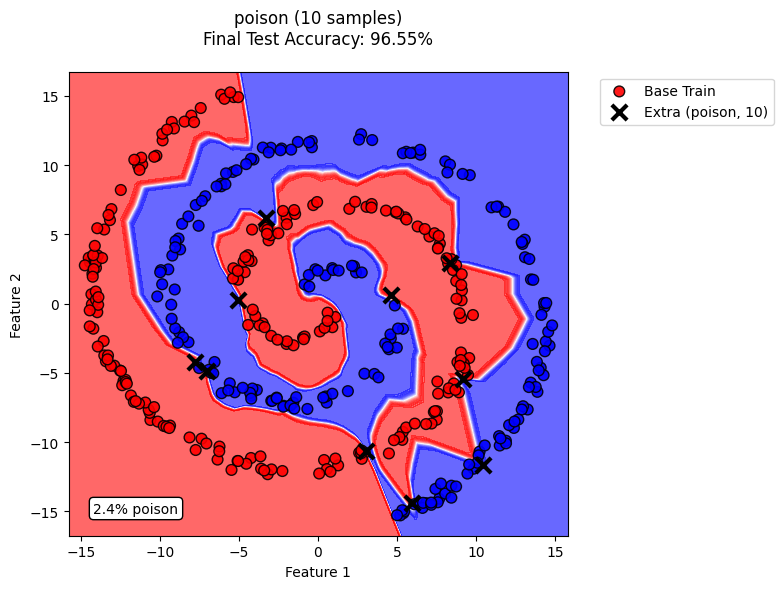

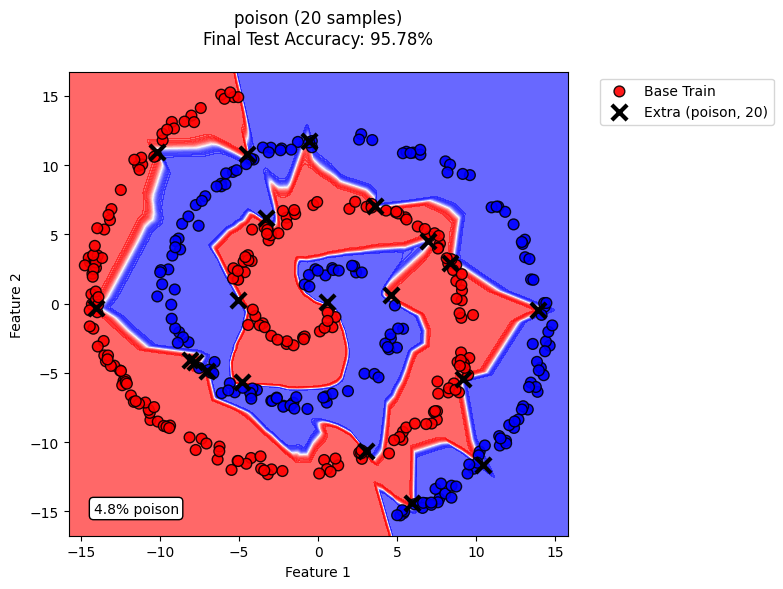

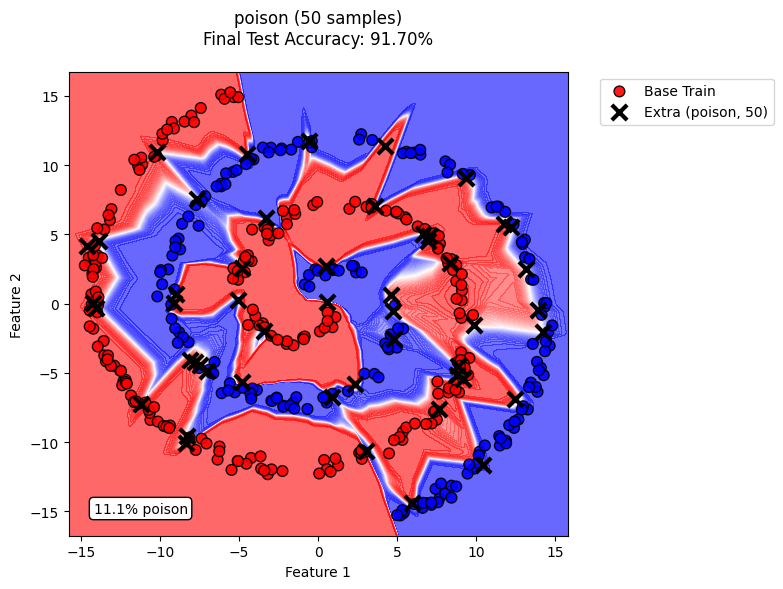

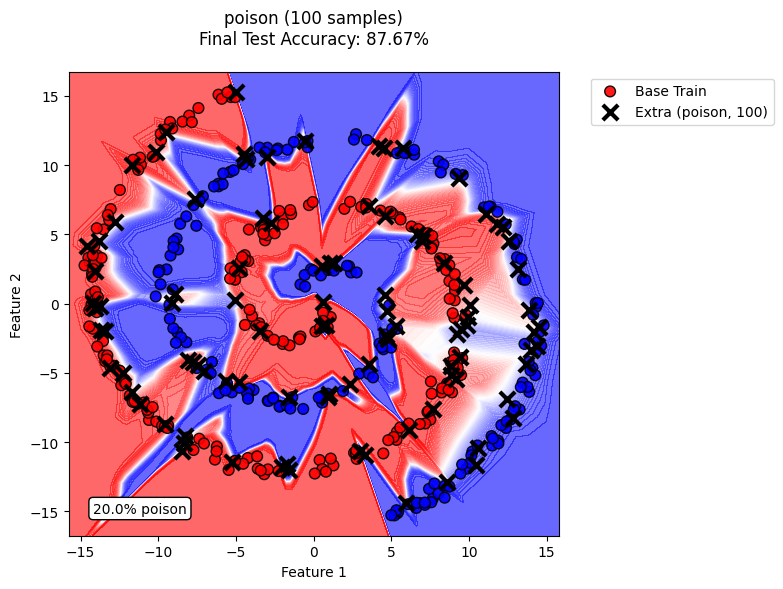

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
